In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt


import xgboost 

In [2]:
# Load data
folder = "2012-and-2016-presidential-elections/"

county_fact_dict = pd.read_csv(folder+"county_facts_dictionary12_16.csv")
county_facts = pd.read_csv(folder+"county_facts12_16.csv")
county_results = pd.read_csv(folder+"US_County_Level_Presidential_Results_12-16.csv")
votes = pd.read_csv(folder+"votes12_16.csv")

In [3]:
county_fact_dict.dtypes

column_name    object
description    object
dtype: object

In [4]:
# Create target variable

def target_function(row):
    if (row['per_dem_2012'] - row['per_dem_2016']) >= 0.15:
        return 1
    else:
        return 0
    
county_results['target'] = county_results.apply(target_function, axis=1)

In [5]:
# Join tables

data = pd.merge(county_results, county_facts, how="inner", left_on="FIPS", right_on="fips" )

In [6]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
data.columns

Index(['combined_fips', 'votes_dem_2016', 'votes_gop_2016', 'total_votes_2016',
       'per_dem_2016', 'per_gop_2016', 'diff_2016', 'per_point_diff_2016',
       'state_abbr', 'county_name', 'FIPS', 'total_votes_2012',
       'votes_dem_2012', 'votes_gop_2012', 'county_fips', 'state_fips',
       'per_dem_2012', 'per_gop_2012', 'diff_2012', 'per_point_diff_2012',
       'target', 'fips', 'area_name', 'state_abbreviation', 'PST045214',
       'PST040210', 'PST120214', 'POP010210', 'AGE135214', 'AGE295214',
       'AGE775214', 'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214',
       'RHI425214', 'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214',
       'POP715213', 'POP645213', 'POP815213', 'EDU635213', 'EDU685213',
       'VET605213', 'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213',
       'HSG495213', 'HSD410213', 'HSD310213', 'INC910213', 'INC110213',
       'PVY020213', 'BZA010213', 'BZA110213', 'BZA115213', 'NES010213',
       'SBO001207', 'SBO315207', 'SBO115207', 'SBO215207'

In [9]:
modelling_col = ['per_dem_2012','PST045214',
       'PST040210', 'PST120214', 'POP010210', 'AGE135214', 'AGE295214',
       'AGE775214', 'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214',
       'RHI425214', 'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214',
       'POP715213', 'POP645213', 'POP815213', 'EDU635213', 'EDU685213',
       'VET605213', 'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213',
       'HSG495213', 'HSD410213', 'HSD310213', 'INC910213', 'INC110213',
       'PVY020213', 'BZA010213', 'BZA110213', 'BZA115213', 'NES010213',
       'SBO001207', 'SBO315207', 'SBO115207', 'SBO215207', 'SBO515207',
       'SBO415207', 'SBO015207', 'MAN450207', 'WTN220207', 'RTN130207',
       'RTN131207', 'AFN120207', 'BPS030214', 'LND110210', 'POP060210']

In [12]:
# Build prediction model

X_train, X_test, y_train, y_test = train_test_split(data[modelling_col], 
                                                    data['target'], 
                                                    test_size=0.33, 
                                                    random_state=42)


In [14]:
# Create model

model = xgboost.XGBRegressor()

In [16]:
model.fit(X_train, y_train)

[18:12:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

82
0.9292900585460124


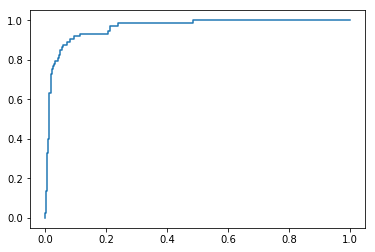

In [27]:
def plot_gini(y_predict, y_actual):
    
    fpr, tpr, thresh = roc_curve(y_actual, y_predict)
    
    #for i in [0.2, 0.4, 0.6, 0.8]:
    #    x_plot.append(1/100)
    print(len(fpr))
    plt.plot(fpr, tpr)
    
plot_gini(model.predict(X_test), y_test)
auc = roc_auc_score(y_test,model.predict(X_test))

print(2*auc-1)
    
        
        